# `<Title>`

Authors:
- Carson Jan
- Ken Yang
- Xiaoheng Wang
- Yunle Xu

DSCI 100 003 <br>
Project Final Report <br>
Group 30

---
# Introduction
## Background infomation on the topic
The project focuses on data from a MineCraft research server set up by UBC Computer Science. The server records player actions, and the goal is to address practical challenges:

1. Player Recruitment: Identifying which types of players contribute the most data to target recruitment effectively.
2. Resource Allocation: Predicting player activity to manage server resources like hardware and licenses.

The main question is: “Which kinds of players are most likely to contribute a large amount of data?”

Using a Jupyter Notebook, the project will clean data, explore patterns, build predictive models, and document results for actionable insights.

## Posted question
We choose the first question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.


## Description of the dataset used
|variable Name|Type|Description|
|---|---|---|
|hashedEmail|character|A hashed version of the player’s email, used to anonymize player identity|
|start_time|character|The start time of the player’s session (needs to be converted to date-time format)|
|end_time|character|The end time of the player’s session (needs to be converted to date-time format)|
|original_start_time|numeric|The exact start time recorded as a timestamp|
|original_end_time|numeric|The exact end time recorded as a timestamp|

|variable Name|Type|Description|
|---|---|---|
|hashedEmail|character|A hashed version of the player’s email, used to anonymize player identity|
|start_time|character|The start time of the player’s session (needs to be converted to date-time format)|
|end_time|character|The end time of the player’s session (needs to be converted to date-time format)|
|original_start_time|numeric|The exact start time recorded as a timestamp|
|original_end_time|numeric|The exact end time recorded as a timestamp|
|experience|character|Player's level of experience (e.g., Pro, Veteran)|
|subscribe|logical|Whether the player has a subscription (TRUE/FALSE)|
|hashedEmail|character|The hashed email of the player to ensure anonymity|
|played_hours|double|Total hours the player has played|
|name|character|The player's name|
|gender|character|The player's gender|
|age|double|The player's age|
|individualId|logical|Indicator of whether the player has an individual ID|
|organizationName|logical|Name of the organization associated with the player|

---
# Methods & Results
## Methods used
## Code

#### Libraries/ initialization

In [54]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(gridExtra)

#### Load data

In [55]:
players <- read_csv('data/players.csv')
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


#### Wrangle & Clean data

In [61]:
mapping_exp <- c("Beginner" = 1, "Amateur" = 2, "Regular" = 3,
                 "Pro" = 4, "Veteran" = 5)
mapping_gender <- c("Male" = 1, "Female" = 2, "Non-binary" = 3,
                 "Agender" = 4, "Two-Spirited" =5, "Other" = 6, "Prefer not to say"=7)

players_clean <- players |>
    mutate(experience2 = as.integer(mapping_exp[experience])) |>
    mutate(subscribe2 = as.integer(subscribe)) |>
    mutate(gender2=as.integer(mapping_gender[gender])) |>
    mutate(gender3=gender) |> mutate(value=1) |> #one hat encoding: this and next line
    pivot_wider(names_from=gender3, names_prefix='gender_', values_from=value, values_fill=0) |> 
    select(-hashedEmail, -name, -individualId, -organizationName) |>
    filter(gender_Other != 1)
    #rm data not important to Qs/NA, rm gender=Other as there is only 1 dp for such var


head(players_clean, 3)


experience,subscribe,played_hours,gender,age,experience2,subscribe2,gender2,gender_Male,gender_Female,gender_Non-binary,gender_Prefer not to say,gender_Agender,gender_Two-Spirited,gender_Other
<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,TRUE,30.3,Male,9,4,1,1,1,0,0,0,0,0,0
Veteran,TRUE,3.8,Male,17,5,1,1,1,0,0,0,0,0,0
Veteran,FALSE,0.0,Male,17,5,0,1,1,0,0,0,0,0,0


#### Summary of dataset
> exploratory data analysis related to the planned analysis 

#### Visualization of dataset 
> exploratory data analysis related to the planned analysis

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


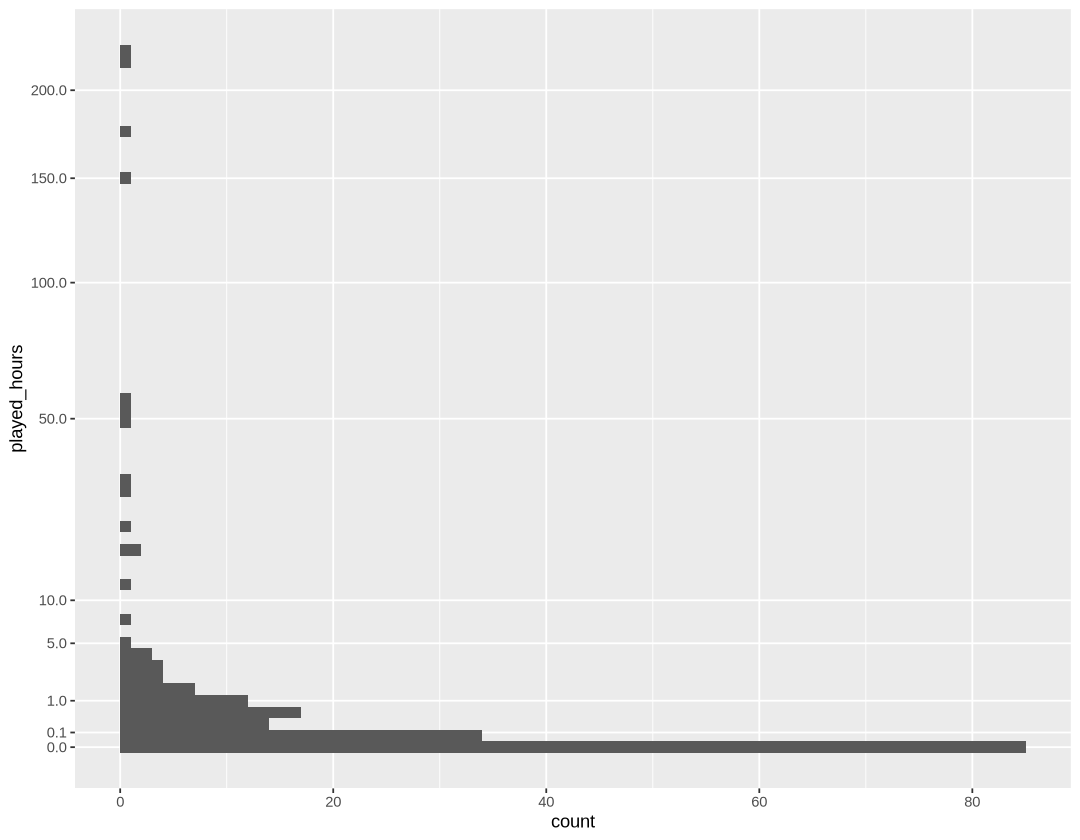

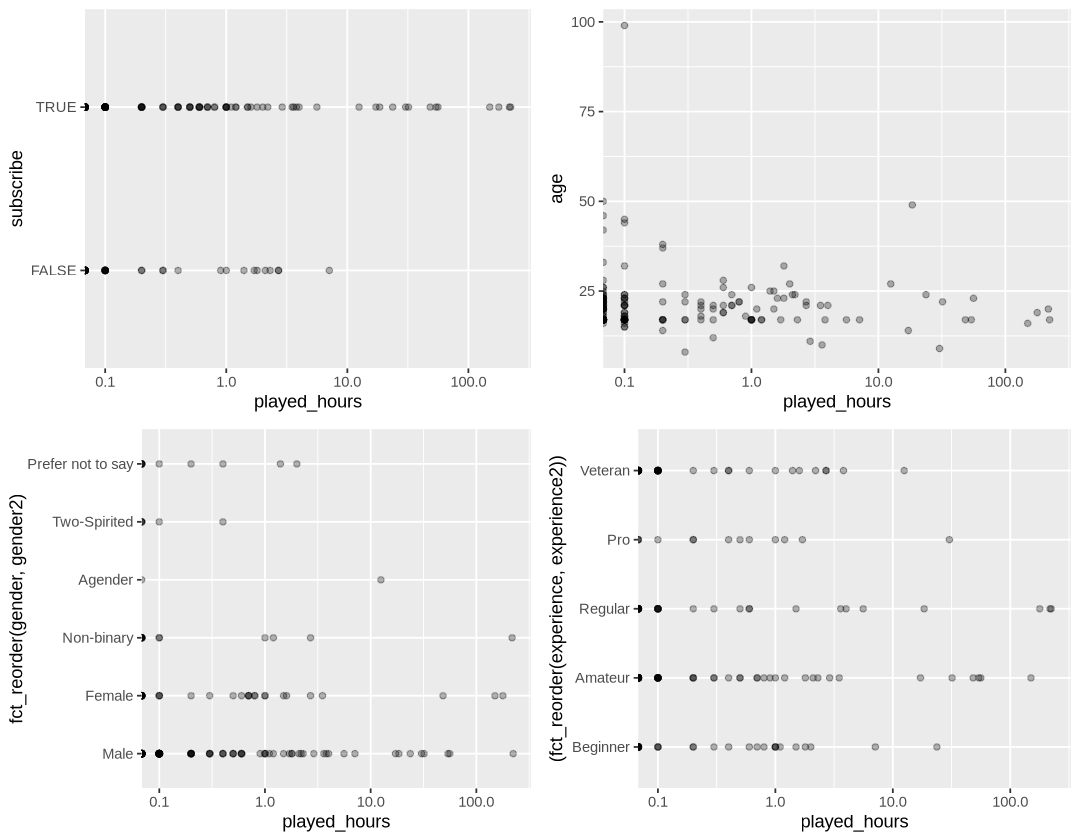

In [62]:
h <- players_clean |>
    ggplot(aes(y=played_hours)) +
    geom_histogram(binwidth=0.25) +
        scale_y_sqrt(breaks = c(0, 0.1 , 1, 5, 10, 50, 100, 150, 200),
                    minor_breaks = NULL)
                    

a <- players_clean |>
    ggplot(aes(x=played_hours, y=age)) +
        geom_point(alpha=0.3) +
        scale_x_log10()


g <- players_clean |>
    ggplot(aes(x=played_hours, 
               y=fct_reorder(gender, gender2))) +
        geom_point(alpha=0.3) +
        scale_x_log10()

e <- players_clean |>
    ggplot(aes(x=played_hours, 
               y=(fct_reorder(experience, experience2)))) +
        geom_point(alpha=0.3) +
        scale_x_log10()

s <- players_clean |>
    ggplot(aes(x=played_hours, y=subscribe)) +
        geom_point(alpha=0.3) +
        scale_x_log10()

options(repr.plot.width=9)
h
grid.arrange(s, a, g, e, ncol=2)

#### Data analysis

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,rmse,standard,28.91059,5,7.300945,Preprocessor1_Model41


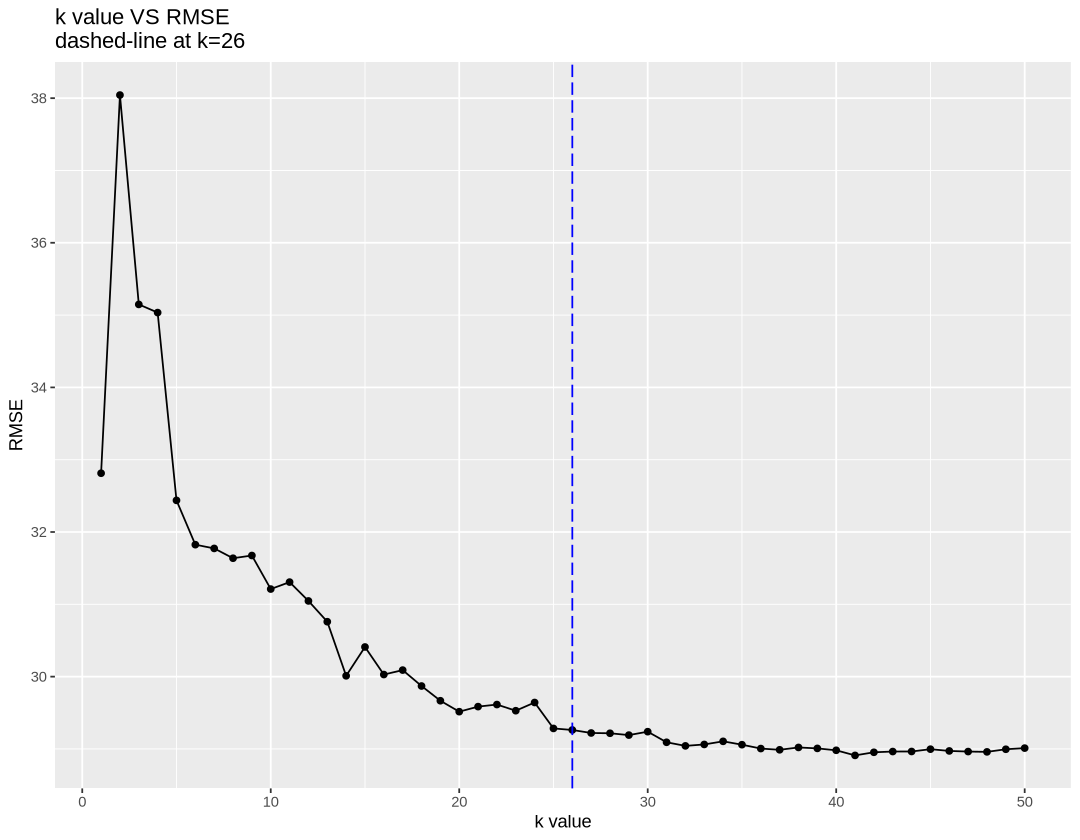

In [63]:
set.seed(1)

players_split <- initial_split(players_clean, prop=0.75, strata=played_hours)
players_training <- training(players_split) |> 
    select(played_hours, 'age':'gender_Two-Spirited', -gender2)
players_testing <- testing(players_split)

recipe_players <- recipe(played_hours ~ ., data=players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

ks <- tibble(neighbors = seq(1,50,1))

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> 
      set_engine('kknn') |>
      set_mode('regression') 

players_vfold <- vfold_cv(players_training, v=5, strata=played_hours)

players_tune <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec_tune)|>
    tune_grid(resample=players_vfold, grid=ks) |>
    collect_metrics() |>
    filter(.metric=='rmse')

slice_min(players_tune, mean, n=1)

players_tune_plot <- players_tune |>
    ggplot(aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x='k value', y='RMSE', title='k value VS RMSE\ndashed-line at k=26') +
    geom_vline(xintercept = 26, color='blue', linetype = "longdash")

players_tune_plot

##### Choice of k value
Although the k value that yields the minimum RMSE is at k=41, it actually brings similar RMSE as k=25. Therefore, we are going to choose k=26 (to speed up the training process)

In [66]:
set.seed(1)

players_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 26) |> 
      set_engine('kknn') |>
      set_mode('regression') 

players_fit <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec)|>
    fit(data=players_training)

players_pred <- players_fit |>
    predict(players_testing) |>
    bind_cols(players_testing)

players_summary <- players_pred |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse")
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.071435


#### Visualization
> note: all figures should have a figure number and a legend

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


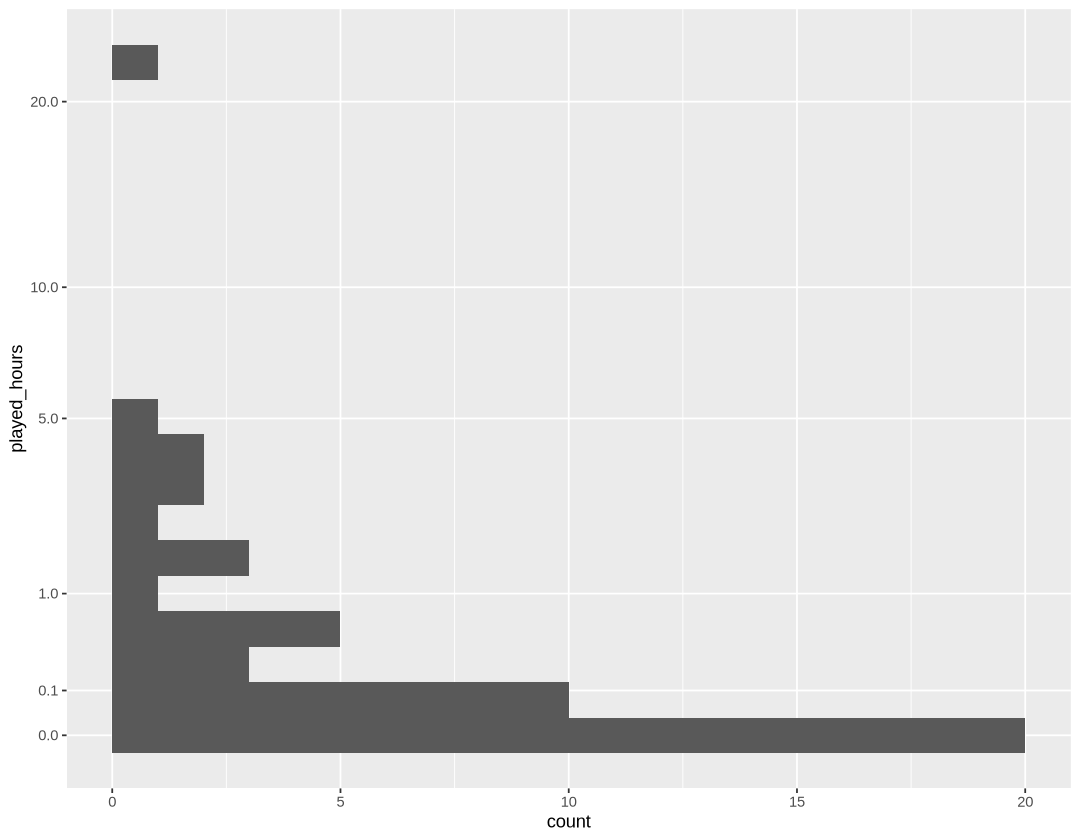

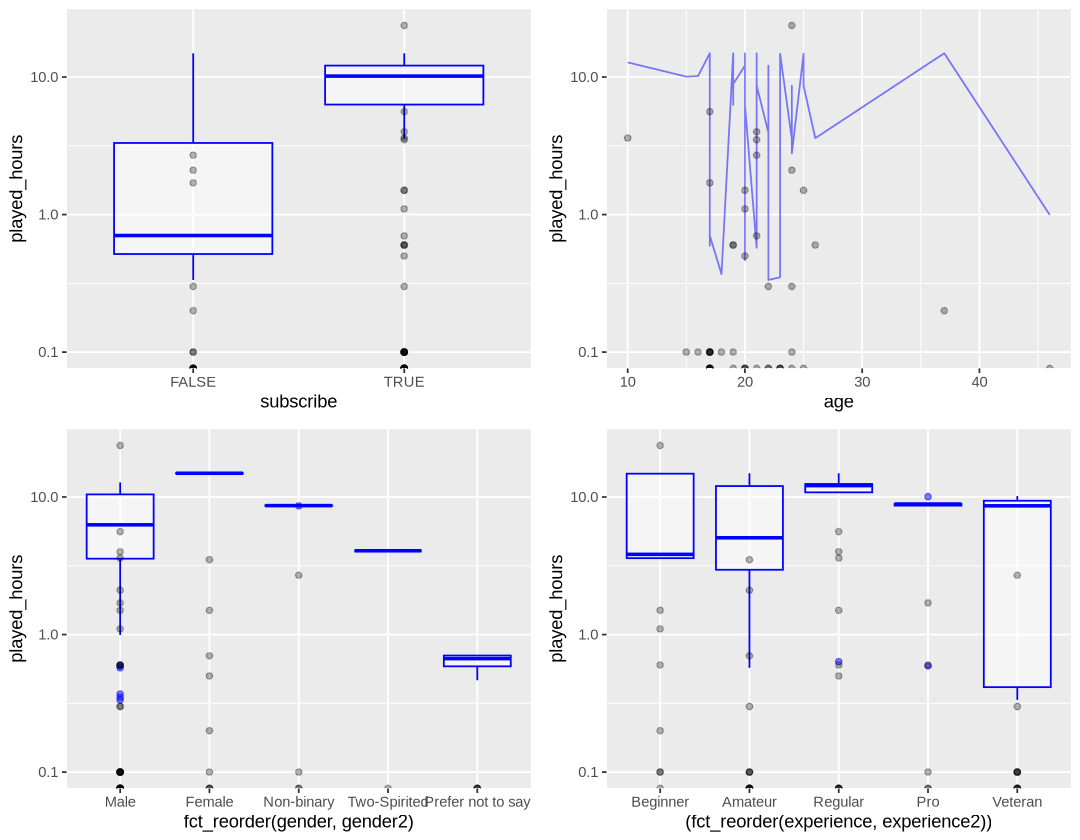

In [79]:
h_pred <- players_pred |>
    ggplot(aes(y=played_hours)) +
    geom_histogram(binwidth=0.25) +
        scale_y_sqrt(breaks = c(0, 0.1 , 1, 5, 10, 20),
                    minor_breaks = NULL)
                    

a_pred <- players_pred |>
    ggplot(aes(x=age, y=played_hours)) +
        geom_line(aes(x=age, y=.pred), color='blue', alpha=0.5) +
        geom_point(alpha=0.3) +
        scale_y_log10()

g_pred <- players_pred |>
    ggplot(aes(y=played_hours, 
               x=fct_reorder(gender, gender2))) +
        geom_boxplot(aes(x=gender, y=.pred), color='blue', alpha=0.5) +
        geom_point(alpha=0.3) +
        scale_y_log10()

e_pred <- players_pred |>
    ggplot(aes(y=played_hours, 
               x=(fct_reorder(experience, experience2)))) +
        geom_boxplot(aes(x=experience, y=.pred), color='blue', alpha=0.5) +
        geom_point(alpha=0.3) +
        scale_y_log10()

s_pred <- players_pred |>
    ggplot(aes(y=played_hours, x=subscribe)) +
        geom_boxplot(aes(x=subscribe, y=.pred), color='blue', alpha=0.5) +
        geom_point(alpha=0.3) +
        scale_y_log10()

options(repr.plot.width=9)
h_pred
grid.arrange(s_pred, a_pred, g_pred, e_pred, ncol=2)

---
# Discussion
## Summarization
## Is it what we expected to found?
## What impact could such findings have
## What future questions chould this lead to?

---
# References
> *note to group members: Use APA 7, please*

---
End of report <br>
Finalized and approved by all group member on `<date>`
> *note to group members: run report through grammar check, please*


To be uploaded by `<member>` by `<date>`